# Load and visualize precomputed samples

In [1]:
import logging
import os

import corner
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from csb.io import load

import geosss as gs
from geosss.spherical_curve import SlerpCurve, brownian_curve

mpl.rcParams["mathtext.fontset"] = "cm"

In [2]:
# `tester` instances samplers
methods = ("sss-reject", "sss-shrink", "rwmh", "hmc")
algos = {
    "sss-reject": "geoSSS (reject)",
    "sss-shrink": "geoSSS (shrink)",
    "rwmh": "RWMH",
    "hmc": "HMC",
}

kappa = 800.0  # concentration parameter
n_samples = int(1e6)  # number of samples per sampler (default: 1000)
burnin = int(0.1 * n_samples)  # burn-in
n_dim = 5  # dimensionality (default: 10)
run_index = 0

# directory to save results
loaddirs = {
    f"vary_kappa_ndim{n_dim}": f"results/curve_{n_dim}d_vary_kappa_nruns_10/curve_{n_dim}d_kappa_{float(kappa)}",  # currently n_dim=5
    f"vary_ndim_kappa_{int(kappa)}": f"results/curve_kappa_{kappa}_vary_ndim_nruns_10/curve_{n_dim}d_kappa_{float(kappa)}",  # currently kappa=500.0
}

# path where the samples are saved
loaddir = loaddirs[f"vary_kappa_ndim{n_dim}"]
loadpath_samples = (
    f"{loaddir}/curve_samples_{n_dim}d_kappa_{float(kappa)}_run{run_index}.pkl"
)
try:
    samples_all = load(loadpath_samples)
    print(f"Samples loaded from {loadpath_samples}.")
    print(f"\n-----INFO------\nkappa: {kappa}\nn_dim: {n_dim}\n---------------")
except FileNotFoundError as e:
    print(e)

Samples loaded from results/curve_5d_vary_kappa_nruns_10/curve_5d_kappa_800.0/curve_samples_5d_kappa_800.0_run0.pkl.

-----INFO------
kappa: 800.0
n_dim: 5
---------------


In [3]:
from geosss.distributions import CurvedVonMisesFisher

# optional controls
is_brownian_curve = True  # brownian curve or curve with fixed knots
reprod_switch = True  # seeds samplers for reproducibility
rerun_if_samples_exists = False  # rerun even if samples file exists

# creating a target as a curve on the sphere
if not is_brownian_curve:
    knots = np.array(
        [
            [-0.25882694, 0.95006168, 0.17433133],
            [0.14557335, 0.61236727, 0.77705516],
            [-0.7973001, -0.25170369, 0.54859622],
            [0.03172733, -0.71944851, 0.69382074],
            [0.56217797, -0.29453368, 0.77279094],
            [0.80883044, 0.1316755, 0.57310983],
            [0.98981463, 0.03039439, -0.13907979],
            [0.81592815, 0.04723609, -0.57622045],
            [0.36888235, 0.400026, -0.83899047],
            [-0.6770828, 0.05213374, -0.73405787],
        ]
    )

    # Pad to match dimensionality if needed
    if n_dim > knots.shape[1]:
        knots = np.pad(knots, ((0, 0), (n_dim - knots.shape[1], 0)))

else:
    # generates a smooth curve on the sphere with brownian motion
    knots = brownian_curve(
        n_points=10,
        dimension=n_dim,
        step_size=0.5,  # larger step size will result in more spread out points
        seed=4562,
    )

print(f"Target curve: {knots}")
# defining the curve on the sphere
curve = SlerpCurve(knots)

# defining this curve as vMF distribution
pdf = CurvedVonMisesFisher(curve, kappa)

Target curve: [[ 0.02636747 -0.14072706  0.93626057 -0.23920124 -0.21377456]
 [ 0.07096614 -0.25028686  0.76417377 -0.58810245 -0.04994251]
 [ 0.21552926  0.03900849  0.77144079 -0.59463745  0.05754035]
 [ 0.26334113 -0.74994064  0.44831589 -0.36188446  0.19050718]
 [ 0.13634453 -0.98266368  0.04152965 -0.00313512  0.11852306]
 [-0.14729166 -0.93792811  0.01092164  0.27199955 -0.15650234]
 [-0.39505787 -0.80283626  0.24512379  0.21200575 -0.30716627]
 [-0.65623213 -0.63599866  0.19619555  0.16593374 -0.31438573]
 [-0.67578922 -0.07993955 -0.3431324   0.54337255 -0.35202985]
 [-0.76440935 -0.14954678 -0.5783955  -0.0745347  -0.23068884]]


### Plot scatter natrix with `corner.corner`

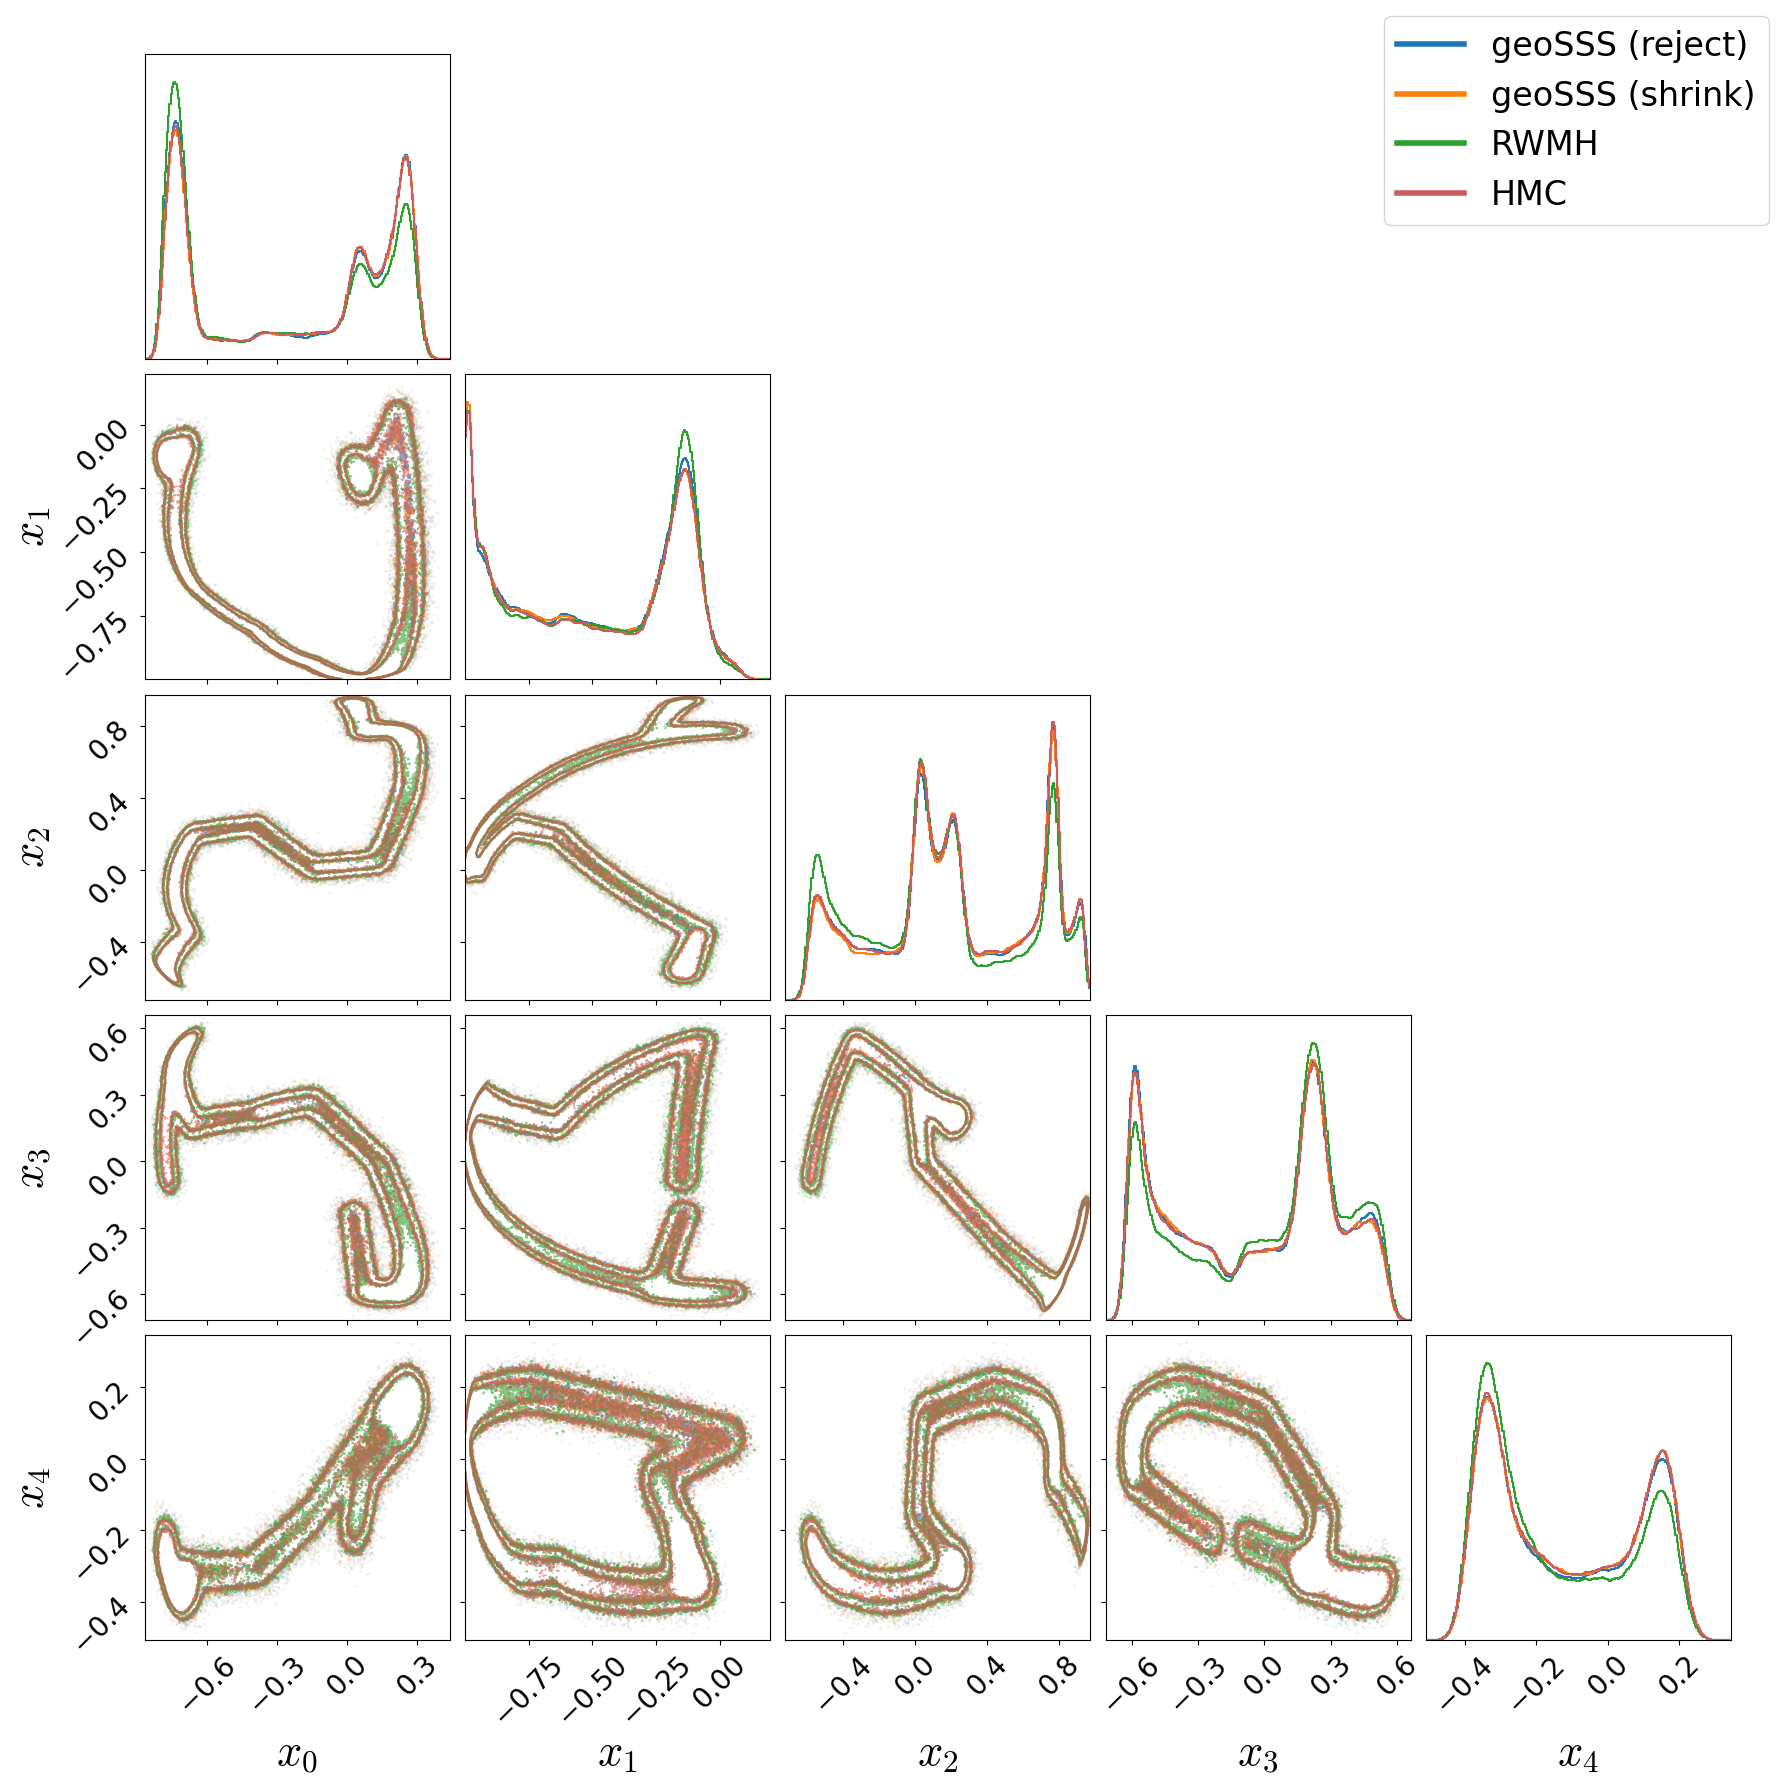

In [4]:
def scatter_matrix(n_dim, samples, methods, algos, loadpath, filename, savefig=False):
    """
    Plotting scatter matrix with the corner library and adjusted label sizes
    """
    # Define font sizes
    label_size = 32  # Size for axis labels
    tick_size = 20  # Size for tick labels
    legend_size = 24  # Size for legend

    # create dir to save scatter matrices
    labels = [rf"$x_{i}$" for i in range(n_dim)]

    # Set default font sizes for matplotlib
    plt.rcParams.update(
        {
            "font.size": tick_size,
            "axes.labelsize": label_size,
            "axes.titlesize": label_size,
            "xtick.labelsize": tick_size,
            "ytick.labelsize": tick_size,
        }
    )

    # Create custom labels for each dataset
    colors = ["tab:blue", "tab:orange", "tab:green", "indianred"]

    figure = plt.figure(figsize=(18, 18))

    for method, color in zip(methods, colors):
        # samples for every method (draws, dimensions)
        samples_per_method = samples[method][: int(1e6)]

        # First corner plot for contours and 1D histograms using all samples
        figure = corner.corner(
            samples_per_method,
            bins=250,
            color=color,
            labels=labels,
            fig=figure,
            plot_density=False,
            plot_contours=True,  # shows the 2D histograms with contours
            contour_kwargs={"alpha": 0.6},
            plot_datapoints=False,
            levels=[0.68, 0.95],
            labelsize=label_size,
            label_kwargs={"fontsize": label_size, "labelpad": 10},
            tick_labels_size=tick_size,
            hist_kwargs={"alpha": 1.0},  # 1D histogram
            smooth1d=2,  # smoothens the 1D histogram
        )

        # Second corner plot for showing fewer scatter points
        figure = corner.corner(
            samples_per_method[::50],
            bins=50,
            color=color,
            plot_density=False,
            plot_contours=False,
            fig=figure,
            plot_datapoints=True,  # only shows the scatter points
            data_kwargs={"alpha": 0.1},
            labels=labels,
            labelsize=label_size,
            label_kwargs={"fontsize": label_size, "labelpad": 10},
            tick_labels_size=tick_size,
            hist_kwargs={"alpha": 0.0},  # 1D histogram disabled
        )

    # Create custom legend with the figure instance
    legend_handles = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]
    figure.legend(
        legend_handles,
        [algos[method] for method in methods],
        loc="upper right",
        fontsize=legend_size,
    )

    # Adjust tick label sizes for all axes
    axes = np.array(figure.axes).reshape((n_dim, n_dim))
    for ax in axes.flat:
        if ax is not None:
            ax.tick_params(labelsize=tick_size)

    # save corner plot
    if savefig:
        savedir = f"{loadpath}/corner_plots"
        os.makedirs(savedir, exist_ok=True)
        logging.info(f"Saving corner plot to {savedir}/{filename}.pdf")
        figure.savefig(f"{savedir}/{filename}.pdf", bbox_inches="tight", dpi=150)


# corner plot (scatter matrix)
scatter_matrix(
    n_dim,
    samples_all,
    methods,
    algos,
    loaddir,
    f"curve_corner_{n_dim}d_kappa{int(kappa)}",
    savefig=True,
)

### Combine ACF and distance plot

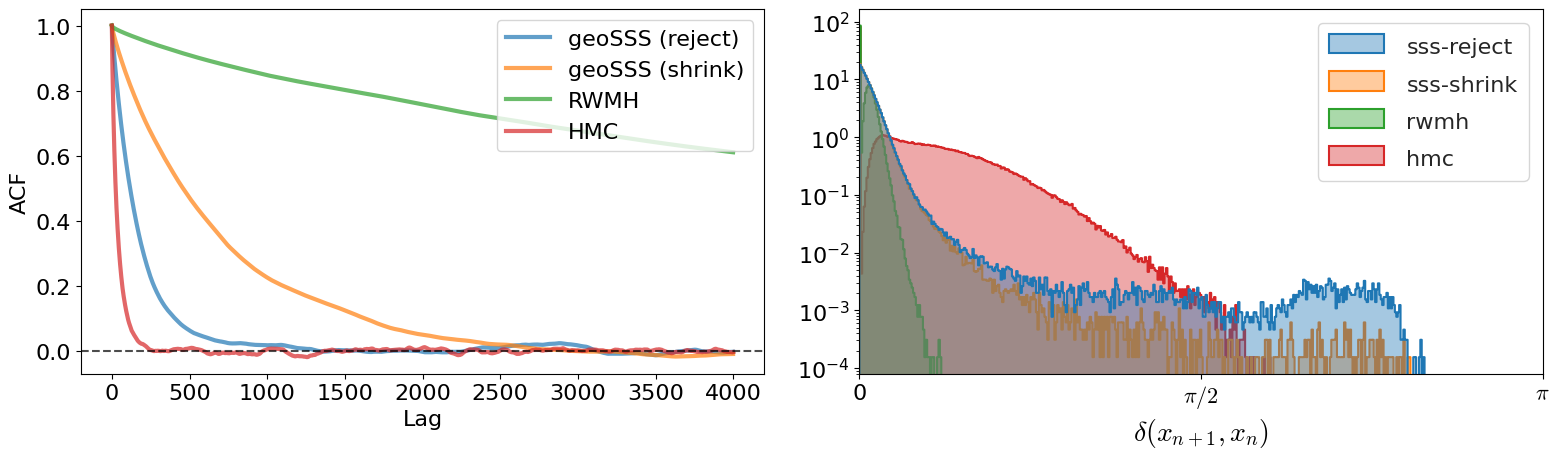

In [5]:
import pandas as pd
import seaborn as sns
import warnings
from arviz import autocorr

# Suppress FutureWarnings (optional)
warnings.filterwarnings("ignore", category=FutureWarning)

# Define methods and corresponding colors
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
method_color_dict = dict(zip(methods, colors))

# Font size for labels and titles
fs = 16

# Create the figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

### First Subplot: Autocorrelation Function ###
ax1 = axes[0]

for method, color in zip(methods, colors):
    ac = autocorr(samples_all[method][:, 0])[:4000]
    ax1.plot(ac, alpha=0.7, lw=3, label=algos[method], color=color)

ax1.axhline(0.0, ls="--", color="k", alpha=0.7)
ax1.set_xlabel(r"Lag", fontsize=fs)
ax1.set_ylabel("ACF", fontsize=fs)
ax1.tick_params(axis="both", which="major", labelsize=fs)
ax1.legend(fontsize=fs, loc="upper right")

### Second Subplot: Geodesic Distance Histogram ###
ax2 = axes[1]

# Prepare the data for the histogram
geo_dist_list = []
for method in methods:
    x = samples_all[method]
    # Compute geodesic distances between successive samples
    geo_dist = gs.sphere.distance(x[:-1], x[1:])
    # Check for Inf or NaN values
    if not np.all(np.isfinite(geo_dist)):
        logging.warning(f"Infinite or NaN values found in geo_dist for method {method}")
        # Remove or handle these values
        geo_dist = geo_dist[np.isfinite(geo_dist)]
    logging.info(
        "average great circle distance of successive samples: "
        f"{np.mean(geo_dist):.2f} ({method})"
    )
    # Create a DataFrame for the current method
    df_method = pd.DataFrame({"geo_dist": geo_dist, "method": method})
    geo_dist_list.append(df_method)

# Combine all DataFrames into one
df_geo_dist = pd.concat(geo_dist_list, ignore_index=True)

# Set the style
sns.set_style("white")  # Remove the background grid

# Create the histogram plot using Seaborn
sns.histplot(
    data=df_geo_dist,
    x="geo_dist",
    hue="method",
    bins=400,
    stat="density",
    element="step",  # Use 'bars' for filled histograms
    fill=True,  # Set to True for filled histograms
    common_norm=False,  # Normalize each histogram independently
    linewidth=1.5,  # Adjust line width for better visibility
    alpha=0.4,
    ax=ax2,
    palette=method_color_dict,
    legend=True,  # Ensure legend is enabled
)

# Customize the x-axis labels and ticks
ax2.set_xlabel(r"$\delta(x_{n+1}, x_n)$", fontsize=20)
ax2.set_xticks([0, np.pi / 2, np.pi])
ax2.set_xticklabels(["0", r"$\pi/2$", r"$\pi$"], fontsize=20)
ax2.tick_params(axis="both", which="major", labelsize=fs)

# Set y-scale to logarithmic
ax2.set_yscale("log")
ax2.set_ylabel(None)  # Remove the y-axis label
ax2.set_xlim(0, np.pi)

# Customize the legend
leg = ax2.get_legend()
if leg is not None:
    leg.set_title(None)  # Remove the legend title
    for t in leg.texts:
        t.set_fontsize(fs)
    # Optionally, adjust the legend location
    leg.set_bbox_to_anchor((1, 1))
else:
    logging.warning("Legend not found in ax2.")


# Adjust layout
fig.tight_layout()

savedir_acf_dist = f"{loaddir}/dist_acf_plots"
os.makedirs(savedir_acf_dist, exist_ok=True)
savefig = False  # save the plots

if savefig:
    fig.savefig(
        f"{savedir_acf_dist}/curve_acf_distplot_run{run_index}.pdf",
        bbox_inches="tight",
        transparent=True,
        dpi=150,
    )

# Plotting the distribution on the 2-sphere

Kappa = 500

In [6]:
import matplotlib.pyplot as plt


In [32]:
from geosss.distributions import Distribution
from scipy.special import logsumexp


def saff_sphere(N: int = 1000) -> np.ndarray:
    """Uniformly distribute points on the 2-sphere using Saff's algorithm."""
    h = np.linspace(-1, 1, N)
    theta = np.arccos(h)
    incr = 3.6 / np.sqrt(N * (1 - h[1:-1] ** 2))
    phi = np.add.accumulate(np.append(0, incr))
    phi = np.append(phi, 0.0)
    x = np.cos(phi) * np.sin(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(theta)
    return np.transpose([x, y, z])


def scatter_curve_3d(
    pdf: Distribution,
    samples: dict,
    METHODS: tuple,
    ALGOS: dict,
    n_saff_samples: int = 30000,
    fontsize=16,
    elev=74,
    azim=-4,
):
    """Visualizing the density and the samples on a 2-sphere

    Parameters
    ----------
    pdf : Distribution
        unnormalized probability density function
    samples : dict
        samples corresponding to each method
    METHODS : tuple
        MCMC methods used here
    ALGOS : dict
        name of the MCMC methods (used for titles)
    n_saff_samples : int, optional
        number of samples for uniformly sampling the sphere, by default 30000
    fontsize : int, optional
        default font size, by default 16
    elev : int, optional
        polar angle for viewing the 3D plot, by default 62
    azim : int, optional
        azimuthal angle for viewing the 3D plot, by default 11

    Returns
    -------
    Figure
        returns the 3D plot
    """
    for method in METHODS:
        assert samples[method].shape[1] == 3, "Visualization accepts only 3D samples."

    # true PDF values
    saff_samples = saff_sphere(n_saff_samples)
    log_p = pdf.log_prob(saff_samples)
    prob_truth = np.exp(log_p - logsumexp(log_p))

    # Create a regular grid over theta and phi for the wire-plot
    theta_grid, phi_grid = np.meshgrid(
        np.linspace(0, np.pi, 300), np.linspace(0, 2 * np.pi, 300)
    )

    # Convert the spherical grid to Cartesian coordinates
    X = np.sin(theta_grid) * np.cos(phi_grid)
    Y = np.sin(theta_grid) * np.sin(phi_grid)
    Z = np.cos(theta_grid)

    # Normalize for color mapping
    fig, axes = plt.subplots(
        1,
        len(METHODS),
        figsize=(16, 6),
        subplot_kw={"projection": "3d"},
        sharex=True,
        sharey=True,
    )

    # Compute the viewing vector
    def _get_view_vector(elev, azim):
        """Convert elevation and azimuth to viewing vector."""
        elev_rad = np.deg2rad(elev)
        azim_rad = np.deg2rad(azim)

        # Adjust azimuth to match Matplotlib's convention
        x = np.cos(elev_rad) * np.cos(azim_rad)
        y = np.cos(elev_rad) * np.sin(azim_rad)
        z = np.sin(elev_rad)
        return np.array([x, y, z])

    # View vector
    view_vector = _get_view_vector(elev, azim)

    for ax, method in zip(axes.flat, METHODS):
        ax.computed_zorder = False
        ax.scatter(
            *saff_samples.T, c=prob_truth, s=10, alpha=0.3, cmap="terrain_r", zorder=1
        )
        # Select the first 10000 samples
        sample_points = samples[method][:10000]
        dot_products = np.dot(sample_points, view_vector)

        # Map dot products to alpha values
        # Desired alpha range: 0.0 (fully transparent) to max_alpha (for visible points)
        min_alpha = 0.0  # Minimum alpha for back-facing points
        max_alpha = 0.16  # Maximum alpha for front-facing points

        # Normalize dot products from [-1, 1] to [min_alpha, max_alpha]
        alpha_values = min_alpha + ((dot_products + 1) / 2) * (max_alpha - min_alpha)
        alpha_values = np.clip(alpha_values, min_alpha, max_alpha)

        # Create colors with varying alpha, base color black
        colors = np.zeros((sample_points.shape[0], 4))
        colors[:, :3] = 0  # for black color
        colors[:, 3] = alpha_values  # custom alpha values

        # scatter points and specify the custom colors
        ax.scatter(*sample_points.T, c=colors, s=1, zorder=2)
        ax.plot_wireframe(X, Y, Z, color="lightgrey", alpha=0.05, zorder=3)

        ax.set_title(ALGOS[method], pad=-50, fontsize=fontsize)
        ax.set_aspect("auto")
        ax.view_init(elev, azim)
        ax.axis("off")

    plt.subplots_adjust(wspace=-0.1, hspace=-0.2)
    plt.show()
    return fig

In [20]:
n_dim = 3
run_index = 0  # index of the run to load samples for 3D curve
loaddir_curve3d = (
    f"results/curve_kappa_500.0_vary_ndim_nruns_10/curve_{n_dim}d_kappa_500.0"
)
samples_curve3d = load(
    f"{loaddir_curve3d}/curve_samples_{n_dim}d_kappa_500.0_run{run_index}.pkl"
)

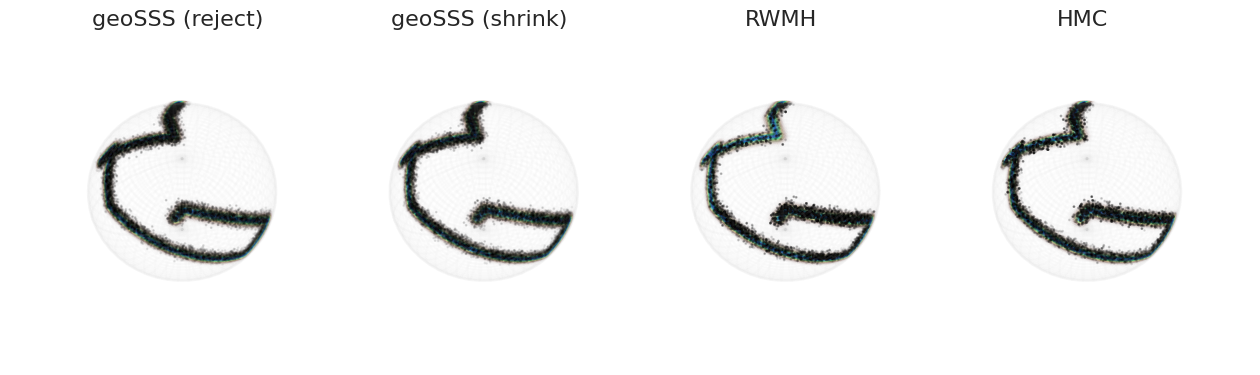

In [33]:
knots = brownian_curve(
    n_points=10,
    dimension=n_dim,
    step_size=0.5,  # larger step size will result in more spread out points
    seed=4562,
)

curve = SlerpCurve(knots)

# Initialize based on dimensionality
initial = (
    np.array([0.65656515, -0.63315859, -0.40991755])
    if n_dim == 3
    else gs.sample_sphere(n_dim - 1, seed=1345)
)

pdf_curved3d = CurvedVonMisesFisher(curve, kappa)
fig = scatter_curve_3d(
    pdf_curved3d,
    samples_curve3d,
    methods,
    algos,
    n_saff_samples=30000,
    fontsize=16,
    elev=120,
    azim=75,
)